In [1]:
import sys

sys.path.append("Users\smoot\Desktop\Stage Mnemosyne\functions")
sys.path.append("Users\smoot\Desktop\Stage Mnemosyne\experience")
sys.path.append("C:\\Users\\smoot\\Desktop\\Stage Mnemosyne")

from functions.functions_untrained_reservoir import *
import functions.functions_data as d

from random import randint

from IPython.display import clear_output

from tqdm import tqdm

from random import randint

from reservoirpy.nodes import Reservoir,FORCE,Ridge
from reservoirpy.mat_gen import Initializer,_scale_spectral_radius,normal
from reservoirpy.observables import spectral_radius

import numpy as np 
import matplotlib.pyplot as plt

# Réseaux de neurones

On cherche ici dans un premier temps à reprdoduire les figures les plus simples de l'article. 

à noter, que la méthode d'entrainement utilisée pour ce script est une méthode dite offline utilisant le noeud Ridge de ReservoirPy. Et qu'un autre script traite de la méthode online pour pouvoir comparer les résultats obtenus.

Données générales 

In [2]:
data = d.extract_data() #Données d'entrée
transcription = d.extract_target() #Données d'arrivée 

#Les données suivantes sont utilisés dans les fonctions mais pas dans le script ! 

freq_ent = 6*10**3  #fréquence d'entrée
T_ent = 1/freq_ent  #période d'entrée

freq_out = 10**3 #fréquence de sortie 
T_out = 1/freq_out #période de sortie

ampl_int = 5 #Amplitude d'entrée

Données du réservoir

In [3]:
N = 210 #Nombre de neurones dans le réservoir
M = 12 #Nombres d'entrées
ridge = 0.01
biais = True
tau = 25*10e-3
dt = 1e-3
lr = dt/tau
sr = 1.0 #spectral radius --> gain ?
g = 1.6 #le gain du réseau ?                             #je comprends pas trop cette donnée. 
connectivity = 0.2 # connectivité entre les neurones (pc dans l'article)
SD = g/np.sqrt(connectivity*N)
mu = 0
I0 = 0 #pendant l'entrainement de la sortie            

Wo = normal(loc=mu,scale = 1/np.sqrt(N))    #Matrice de sortie : Non utilisée

enregistrement = False

Création de la matrice du réservoir : avec pas d'autapses

In [4]:
W_r.init = Initializer(W_r)

W = _scale_spectral_radius(W_r.init, [N,N], sr)

W = W.toarray()

Création de la matrice d'entrée : chaque entrée k est projetée sur le neurone $(k-1)\frac{N}{M} + 1$ jusqu'au neurone $k\frac{N}{M}$ selon une loi normale 

In [5]:
Win = W_in(N,M)

## Première expérience

Création des données d'entrée

In [6]:
X_input = []
X_target = []
for indS in [1] : 
    for indU in range(1,6):
        for indD in range(10):
            X_input.append(np.transpose(formatage_cocleogram(indS, indU, indD,data)))
            X_target.append(target_xyz(indS, indU, indD,data))
            

Création du réservoir offline

In [7]:
reservoir_offline, readout_offline = Reservoir(units = N,
                                               lr = lr,
                                               sr=sr,
                                               W=W,
                                               Win=Win,
                                               equation="external",
                                               input_bias=biais,
                                               noise_rc = I0), Ridge(ridge = ridge)
esn_offline = reservoir_offline >> readout_offline

Entrainement du réservoir

In [8]:
#entrainement du réservoir


for i in tqdm(range(25)) :
    
    print("Entrainements numéro : ",(i+1) * len(X_input))
    
    esn_offline.fit(X_input,X_target,stateful=False)

    
    if enregistrement == True:
        
        print("enregistrement fichier")
        
        W_out_train = readout_offline.get_param("Wout")
        
        entrance_matrice = [Win,W,Wo]
        trained_matrice = [W,W_out_train]

        chemin = 'C:/Users/smoot/Desktop/Stage Mnemosyne/experience'

        name, namefile = d.save_seed(entrance_matrice,
                                  trained_matrice,
                                  chemin = chemin,
                                  methode = "Géneration de seed avec un ESN méthode offline",
                                  N = N,
                                  sr = sr,
                                  biais = biais,
                                  I0 = I0,
                                  nb_learning_trials_rec=0,
                                  nb_learning_trials_readout=(i+1)*len(X_input),
                                  entrainement = "indU de 1 à 5")
        
        
        """
        test des différentes fonctions et sauvegarde
        """
        
        for i in [0,1]:
            #Test du réservoir
            indS,indU,indD = 1,randint(1+i*5,5+i*5),randint(0,9)
            X_test = np.transpose(formatage_cocleogram(indS,indU,indD,data))
            xyz = esn_offline.run(X_test)
    
            #récupération des états des neurones
            states = etat(reservoir_offline,indS,indU,indD,data)

            #récupération de l'erreur commise
            erreur = error(xyz,indS,indU,indD,data)
        
            affiche(xyz,indS,indU,indD,data,states,erreur,mode = "offline",filename = namefile,sr = sr,N=N,I0 = I0)
            
            
            #Test du réservoir sur les 10 chiffres:
            liste_chiffre=[]
            indS, indU = 1,randint(1+i*5,5+i*5)
            for i in range(10):
                X_test = np.transpose(formatage_cocleogram(indS,indU,i,data))
                liste_chiffre.append(esn_offline.run(X_test))
    
            affiche_chiffre(liste_chiffre,indS,indU,data,mode="offline",filename = namefile,sr = sr,N=N,I0 = I0)
        
        clear_output
        
clear_output()

Récupération des poids de sorties 

34.10730053691073


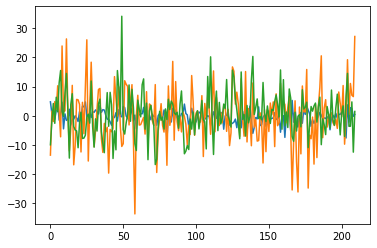

In [9]:
poids_sortie = readout_offline.get_param("Wout")
plt.plot(poids_sortie)
print(np.max(poids_sortie))

### TEST 1 :

Sur des données d'entrainements :

   - le premier graphique est le détail des activités du réservoir pour un chiffre donné.
    
   - le second, c'est la sortie du réservoir pour les 10 chiffres d'un sujet donné et d'une entrée.





###### 1 chiffre

In [10]:
#Test du réservoir
indS,indU,indD = 1,3,6
X_test = np.transpose(formatage_cocleogram(indS,indU,indD,data))
xyz = esn_offline.run(X_test)
   
#Récuperation des états des neurones
states = etat(reservoir_offline,indS,indU,indD,data)
#Récupération de l'erreur commise (distance euclidienne ici)
erreur = error(xyz,indS,indU,indD,data)

Running Model-0: 1886it [00:00, 3071.57it/s]                                                                           
Running Reservoir-0: 100%|███████████████████████████████████████████████████████| 1886/1886 [00:00<00:00, 4697.76it/s]


Affichage du chiffre :

C:\Users\smoot\Desktop\Stage Mnemosyne\functions\functions_untrained_reservoir.py:237: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


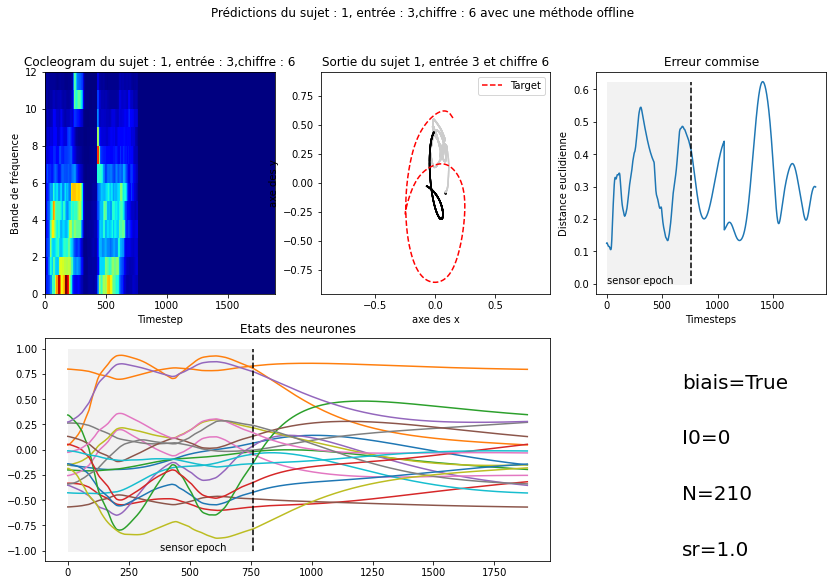

In [11]:
affiche(xyz,indS,indU,indD,data,states,erreur,mode = "offline",sr = sr,N = N,I0=I0,biais = biais)

Pour l'affichage du chiffre, le gris représente la où passe le réservoir sans mettre le stylo sur la feuille, et en noir, la où il écrit.

###### 10 chiffres

In [12]:
#Test du réservoir sur les 10 chiffres:
liste_chiffre=[]
indS, indU = 1,1
for i in range(10):
    X_test = np.transpose(formatage_cocleogram(indS,indU,i,data))
    liste_chiffre.append(esn_offline.run(X_test))

Running Model-0: 1671it [00:00, 3299.84it/s]                                                                           
Running Model-0: 970it [00:00, 2921.26it/s]                                                                            
Running Model-0: 1512it [00:00, 2976.25it/s]                                                                           
Running Model-0: 1790it [00:00, 3128.67it/s]                                                                           
Running Model-0: 1295it [00:00, 3304.43it/s]                                                                           
Running Model-0: 1931it [00:00, 3093.81it/s]                                                                           
Running Model-0: 1886it [00:00, 3205.17it/s]                                                                           
Running Model-0: 1395it [00:00, 3114.30it/s]                                                                           
Running Model-0: 1566it [00:00, 3070.00i

Ensuite on affiche tout les chiffres :

C:\Users\smoot\Desktop\Stage Mnemosyne\functions\functions_untrained_reservoir.py:302: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


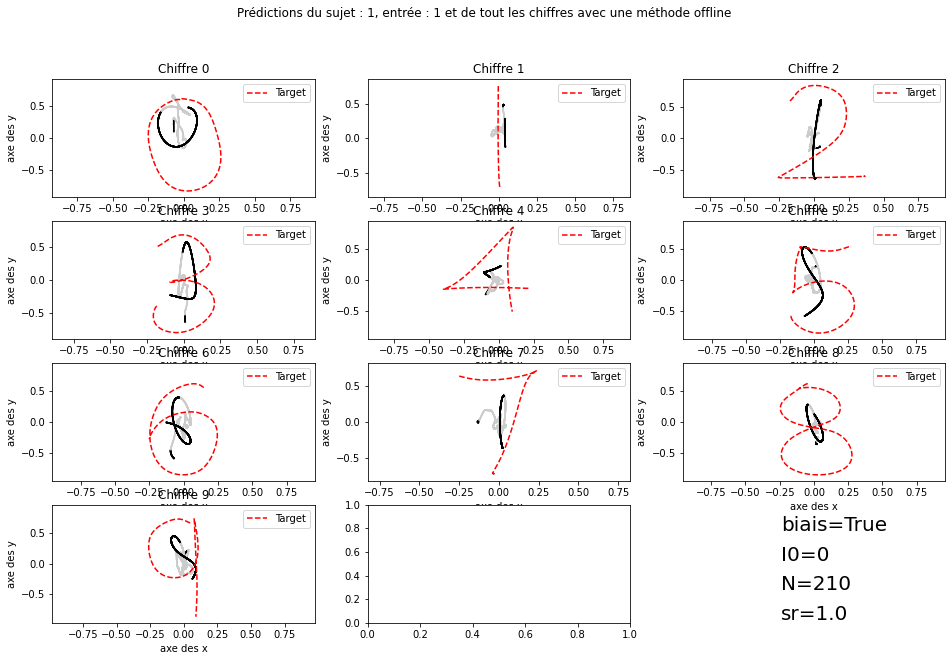

In [13]:
affiche_chiffre(liste_chiffre,indS,indU,data,mode="offline",sr = sr,N=N,I0 = I0,biais=biais)

### Test 2 :

Même principe mais cette fois si ce ne sont pas des données d'entrainement.

###### 1 chiffre

In [14]:
#Test du réservoir
indS,indU,indD = 1,4,6
X_test = np.transpose(formatage_cocleogram(indS,indU,indD,data))
xyz = esn_offline.run(X_test)
   
#Récuperation des états des neurones
states = etat(reservoir_offline,indS,indU,indD,data)

#Récupération de l'erreur commise (distance euclidienne ici)
erreur = error(xyz,indS,indU,indD,data)

Running Model-0: 1919it [00:00, 3156.48it/s]                                                                           
Running Reservoir-0: 100%|███████████████████████████████████████████████████████| 1919/1919 [00:00<00:00, 5275.75it/s]


Affichage du chiffre

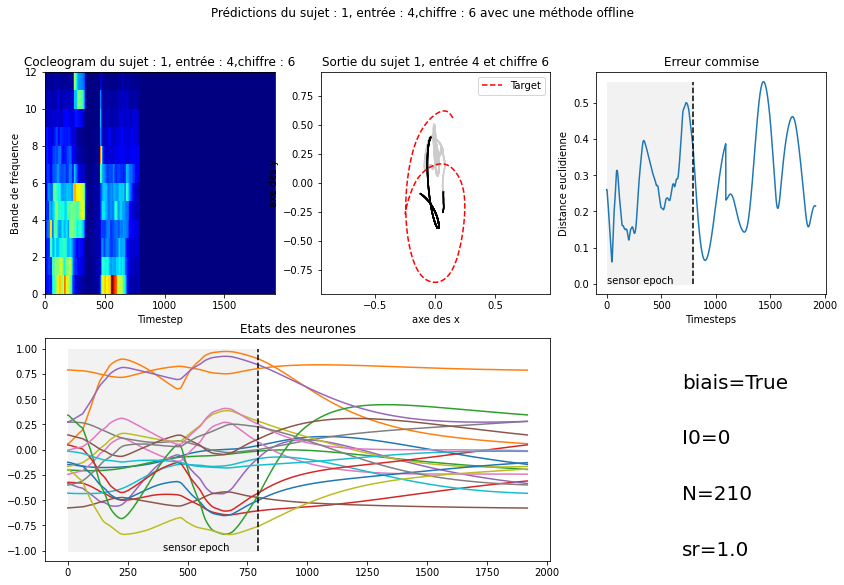

In [16]:
affiche(xyz,indS,indU,indD,data,states,erreur,mode = "offline",sr = sr,N=N,I0 = I0,biais = biais)

###### 10 chiffres

In [17]:
#Test du réservoir sur les 10 chiffres:
liste_chiffre=[]
indS, indU = 1,5
for i in range(10):
    X_test = np.transpose(formatage_cocleogram(indS,indU,i,data))
    liste_chiffre.append(esn_offline.run(X_test))

Running Model-0: 1752it [00:00, 3471.47it/s]                                                                           
Running Model-0: 901it [00:00, 3194.42it/s]                                                                            
Running Model-0: 1408it [00:00, 3585.64it/s]                                                                           
Running Model-0: 1753it [00:00, 3478.86it/s]                                                                           
Running Model-0: 1271it [00:00, 3183.94it/s]                                                                           
Running Model-0: 1891it [00:00, 3296.51it/s]                                                                           
Running Model-0: 1873it [00:00, 3177.51it/s]                                                                           
Running Model-0: 1447it [00:00, 3540.92it/s]                                                                           
Running Model-0: 1677it [00:00, 3273.75i

Affichage du graphique

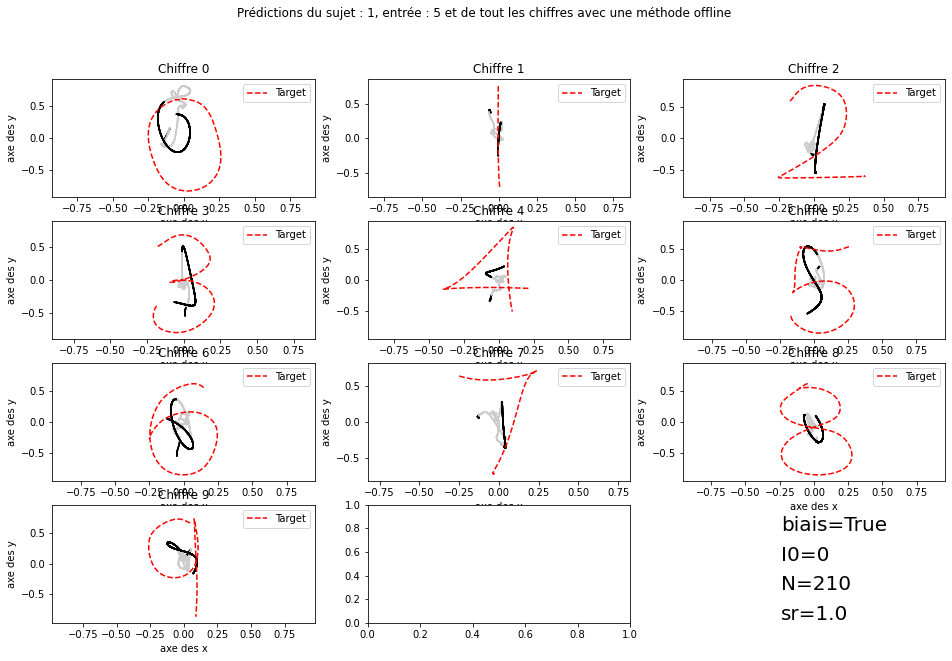

In [19]:
affiche_chiffre(liste_chiffre,indS,indU,data,mode="offline",sr = sr,N=N,I0 = I0,biais=biais)